In [1]:
import numpy as np
import pandas as pd
from zipfile import ZipFile

# Feature selection
from scipy.stats import pearsonr
from sklearn.feature_selection import mutual_info_classif, f_classif

# Models
from scipy.spatial.distance import euclidean, mahalanobis
from sklearn.metrics.pairwise import rbf_kernel

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, StratifiedKFold, StratifiedShuffleSplit
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import RandomOverSampler
from sklearn.decomposition import PCA
from scipy.stats import gmean

# Model evaluation
from sklearn import metrics
from kneed import KneeLocator

# Plotting and table formatting
import matplotlib.pyplot as plt
from IPython.display import Markdown
from tabulate import tabulate
import seaborn as sb
from collections import Counter
from tqdm.notebook import tqdm

# System modules
import re
import itertools
import os
import sys
sys.path.append('../')

# Custom modules
from vibrodiagnostics import (
    mafaulda,
    discovery, 
    selection,
    models
)
PATH_PREFIX = '../../datasets/'
FEATURES_PATH =  os.path.join(PATH_PREFIX, 'features_data')

TD_FD_FEATURES = os.path.join(FEATURES_PATH, selection.TIME_AND_FREQ_FEATURES_PATH)
TD_FEATURES = os.path.join(FEATURES_PATH, selection.TIME_FEATURES_PATH)
FD_FEATURES = os.path.join(FEATURES_PATH, selection.FREQ_FEATURES_PATH)

domains = {'temporal': TD_FEATURES, 'spectral': FD_FEATURES}
rpm_limit = [False, True]
target = ['fault', 'anomaly_60', 'anomaly_90']
placement = ['A', 'B']
online = [False]

Parameters:
- Distance metric
- k neighbours (odd numbers because of majority voting) - elbow curve

### Temporal features

In [2]:
def knn_evaluation(x_train, y_train, x_test, y_test):
    knn = KNeighborsClassifier(n_neighbors=5, metric='euclidean', algorithm='kd_tree')
    knn.fit(x_train, y_train)
    y_predict_train = knn.predict(x_train)
    y_predict_test = knn.predict(x_test)

    print(f'Train accuracy: {metrics.accuracy_score(y_train, y_predict_train) * 100:.2f} %')
    print(f'Test accuracy: {metrics.accuracy_score(y_test, y_predict_test) * 100:.2f} %')
    print(metrics.classification_report(y_test, y_predict_test))

    labels = np.unique(y_test)
    cm = metrics.confusion_matrix(y_test, y_predict_test)
    cm = pd.DataFrame(cm, index=labels, columns=labels)

    ax = sb.heatmap(cm, cbar=True, cmap='BuGn', annot=True, fmt='d')
    ax.set_xlabel('Predicted label')   #,size=15)
    ax.set_ylabel('True label')      #, size=15)
    plt.show()


def knn_one_case_eval(neighbours, features, x_train, y_train, x_test, y_test):
    x_train_selected = x_train[features]
    x_test_selected = x_test[features]

    knn = KNeighborsClassifier(n_neighbors=neighbours, metric='euclidean', algorithm='kd_tree')
    knn.fit(x_train_selected, y_train)
    y_predict_train = knn.predict(x_train_selected)
    y_predict_test = knn.predict(x_test_selected)

    y_proba_train = knn.predict_proba(x_train_selected)
    y_proba_test = knn.predict_proba(x_test_selected)

    return {
        'features': features,
        'train_accuracy': metrics.accuracy_score(y_train, y_predict_train),
        'train_precision': metrics.precision_score(y_train, y_predict_train, average='micro'),
        'train_recall': metrics.recall_score(y_train, y_predict_train, average='micro'),
        'train_error_rate': np.mean(y_train != y_predict_train),
        # 'train_auc': metrics.roc_auc_score(y_train, y_proba_train, multi_class='ovo', average='macro'), # class imbalance insensivity
        'test_accuracy': metrics.accuracy_score(y_test, y_predict_test),
        'test_precision': metrics.precision_score(y_test, y_predict_test, average='micro'),
        'test_recall': metrics.recall_score(y_test, y_predict_test, average='micro'),
        'test_error_rate': np.mean(y_test != y_predict_test)
        #'test_auc': metrics.roc_auc_score(y_test, y_proba_test, multi_class='ovo', average='macro')
    }

def knn_feature_combinations(neighbours, all_features, combinations, x_train, y_train, x_test, y_test):
    evaluation = []

    for features in tqdm(itertools.combinations(all_features, r=combinations)):
        result = knn_one_case_eval(neighbours, list(features), x_train, y_train, x_test, y_test)
        evaluation.append(result)

    evaluation = pd.DataFrame.from_records(evaluation)
    return evaluation.sort_values(by='train_accuracy', ascending=False).reset_index(drop=True)

In [17]:
def load_source(dataset: str, domain: str, row: dict):
    faults = {
        'A': {
            'normal': 'normal',
            'imbalance': 'imbalance',
            'horizontal-misalignment': 'misalignment',
            'vertical-misalignment': 'misalignment',
            'underhang-outer_race': 'outer race fault',
            'underhang-cage_fault': 'cage fault',
            'underhang-ball_fault': 'ball fault'
        },
        'B': {
            'normal': 'normal',
            'imbalance': 'imbalance',
            'horizontal-misalignment': 'misalignment',
            'vertical-misalignment': 'misalignment',
            'overhang-cage_fault': 'cage fault',
            'overhang-ball_fault': 'ball fault',
            'overhang-outer_race': 'outer race fault'
        }
    }
    placements = {
        'A': ['ax', 'ay', 'az'],
        'B': ['bx', 'by', 'bz']
    }
    RPM = 2500              # TODO: more rpm ranges
    RPM_RANGE = 500
    features = pd.read_csv(dataset).fillna(0)

    # Choosing rpm range
    if row['rpm_limit']:
        features = features[features['rpm'].between(RPM - RPM_RANGE, RPM + RPM_RANGE, inclusive='both')]

    # Labeling anomaly severity levels
    target = re.search(r'([a-z]+)_?(\d+)?', row['target'])
    anomaly_severity = target.group(2) or '60'
    anomaly_severity = float(anomaly_severity) / 100

    # Choose measurement placement: A or B
    place = row['placement']
    axis = placements[place]
    features = features[features['fault'].isin(tuple(faults[place]))]
    features = models.fault_labeling(features, faults[place], anomaly_severity) #, debug=True)

    ##############################################
    # ?assign normal class to low severity faults
    # features.loc[features['severity_level'] < 0.5, 'fault'] = 'normal'

    columns = features.columns.str.startswith(tuple(axis))
    X = features[features.columns[columns]]

    # Select predicted variable column
    label = target.group(1)
    Y = features[label].astype('category')

    # Filter columns in feature domain with window size 2**14
    if domain == 'spectral':
        window_size = 2**14
        X = X.loc[:,X.columns.str.endswith(f'_{window_size}')]
        X.columns = X.columns.str.extract(r'(\w+)_\w+$')[0]

    # Calculate feature magnitudes from 3D vector
    feature_names = get_features_list({domain: dataset})
    result = pd.DataFrame()
    for name in feature_names:              
        # Remove prefix: temporal, spectral
        name = re.search(r'[a-z]+_([\w\_]+)', name).group(1)
        vector_dims = [f'{dim}_{name}' for dim in axis]
        result[name] = X[vector_dims].apply(np.linalg.norm, axis=1)
    X = result

    # Batch / Online hold-out (balance and event sequencing)
    train_size = 0.8
    if 'online' in row and row['online']:
        # Shuffle order within severity level and order event with increasing severity
        groups = [
            df.sample(frac=1, random_state=10)
            for i, df in (
                features.sort_values(by='severity_level').groupby('severity_level')
            )
        ]
        rows = list(pd.concat(groups).index)
        X = X.loc[rows].reset_index(drop=True)
        Y = Y.loc[rows].reset_index(drop=True)

        X_train, X_test, Y_train, Y_test = train_test_split(
            X, Y, train_size=train_size, random_state=10
        )   
        X_train, X_test, Y_train, Y_test = (
            X_train.sort_index(), X_test.sort_index(),
            Y_train.sort_index(), Y_test.sort_index()
        )

    else:
        oversample = RandomOverSampler(sampling_strategy='not majority', random_state=10)
        X, Y = oversample.fit_resample(X, Y.to_numpy())
        X.reset_index(drop=True, inplace=True)
        Y = pd.Series(Y)

        X_train, X_test, Y_train, Y_test = train_test_split(
            X, Y, train_size=train_size, stratify=Y, random_state=10
        )

        ################ KEEP HERE ############################x
        scaler = MinMaxScaler()
        X_train[X_train.columns] = scaler.fit_transform(X_train)
        X_test[X_test.columns] = scaler.transform(X_test)
        ##############################################

    return X_train, X_test, Y_train, Y_test


def get_features_list(domains):
    features = []
    for dname, dataset in domains.items():
        names = pd.read_csv(dataset)
        names = names.columns.str.extract(r'([a-z]{2})_([a-z\_\-]+)')[1].unique()
        features.extend([f'{dname}_{col.strip("_")}' for col in names if not pd.isnull(col)])

    return features

def knn_fsel_evaluation(domain, source, neighbours=5, filename='best_set/rank_product.csv'):
    columns = get_features_list({domain: source})
    best_set_membership = pd.read_csv(os.path.join('../FeatureSelection/', filename))

    model = []
    groupby_columns = ['rpm_limit', 'target', 'placement']
    for key, group in tqdm(best_set_membership.groupby(by=groupby_columns)):
        situation = group[columns][group == True].count(axis=0).sort_values(ascending=False).head(3)
        features = [re.search(r'[a-z+]_(\w+)', s).group(1) for s in situation.index]

        result = dict(zip(groupby_columns, key))
        x_train, x_test, y_train, y_test = load_source(source, domain, result)
        score = knn_one_case_eval(neighbours, features, x_train, y_train, x_test, y_test)

        result.update(score)
        model.append(result)

    return pd.DataFrame.from_records(model)

def knn_neighbours_eval(domain, dataset):
    train_rates = pd.DataFrame()
    test_rates = pd.DataFrame()
    for n in range(3, 21, 2):
        scores = (
            knn_fsel_evaluation(domain, dataset, neighbours=n)
            .drop(columns=['features'])
            .set_index(['rpm_limit', 'target', 'placement'])
        )
        train_rates[n] = scores['train_error_rate']
        test_rates[n] = scores['test_error_rate']
    return train_rates, test_rates

#### Classification with kNN (all features)

Train accuracy: 95.90 %
Test accuracy: 93.45 %
                  precision    recall  f1-score   support

      ball fault       0.98      1.00      0.99       738
      cage fault       0.97      1.00      0.98       738
       imbalance       0.95      0.98      0.96       738
    misalignment       0.84      0.93      0.88       738
          normal       0.90      0.70      0.79       738
outer race fault       0.98      1.00      0.99       738

        accuracy                           0.93      4428
       macro avg       0.93      0.93      0.93      4428
    weighted avg       0.93      0.93      0.93      4428



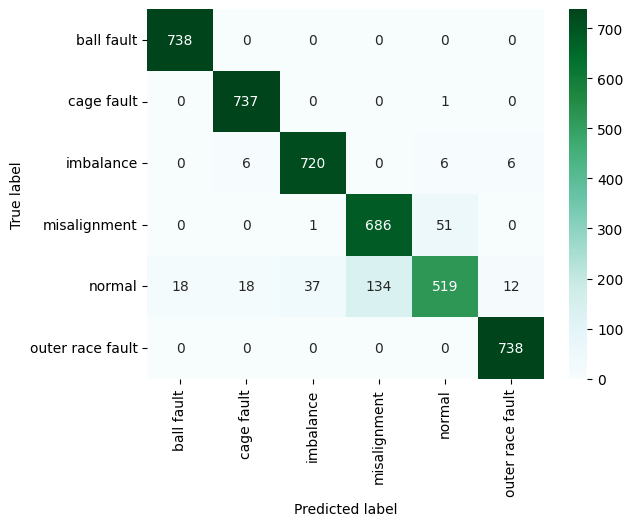

In [9]:
# Time domain to fault
row = {'rpm_limit': False, 'target': 'fault', 'placement': 'A', 'online': False}
x_train, x_test, y_train, y_test = load_source(TD_FEATURES, 'temporal', row)
knn_evaluation(x_train, y_train, x_test, y_test)

Train accuracy: 98.92 %
Test accuracy: 97.85 %
                  precision    recall  f1-score   support

      ball fault       0.99      1.00      1.00       738
      cage fault       0.99      1.00      1.00       738
       imbalance       0.99      0.99      0.99       738
    misalignment       0.93      0.99      0.96       738
          normal       0.99      0.88      0.93       738
outer race fault       0.98      1.00      0.99       738

        accuracy                           0.98      4428
       macro avg       0.98      0.98      0.98      4428
    weighted avg       0.98      0.98      0.98      4428



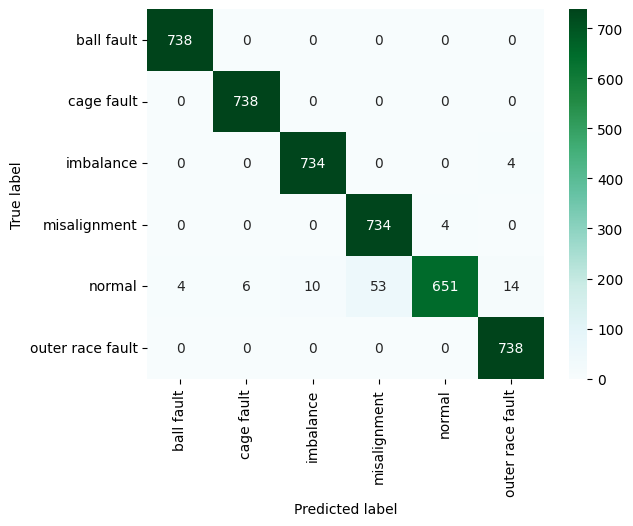

In [10]:
row = {'rpm_limit': False, 'target': 'fault', 'placement': 'A', 'online': False}
x_train, x_test, y_train, y_test = load_source(FD_FEATURES, 'spectral', row)
knn_evaluation(x_train, y_train, x_test, y_test)

In [ ]:
row = {'rpm_limit': False, 'target': 'anomaly_90', 'placement': 'A', 'online': False}
x_train, x_test, y_train, y_test = load_source(TD_FEATURES, 'temporal', row)
knn_evaluation(x_train, y_train, x_test, y_test)

In [ ]:
row = {'rpm_limit': False, 'target': 'anomaly_90', 'placement': 'A', 'online': False}
x_train, x_test, y_train, y_test = load_source(FD_FEATURES, 'spectral', row)
knn_evaluation(x_train, y_train, x_test, y_test)

B

In [ ]:
row = {'rpm_limit': False, 'target': 'fault', 'placement': 'B', 'online': False}
x_train, x_test, y_train, y_test = load_source(TD_FEATURES, 'temporal', row)
knn_evaluation(x_train, y_train, x_test, y_test)

In [ ]:
row = {'rpm_limit': False, 'target': 'fault', 'placement': 'B', 'online': False}
x_train, x_test, y_train, y_test = load_source(FD_FEATURES, 'spectral', row)
knn_evaluation(x_train, y_train, x_test, y_test)

In [ ]:
row = {'rpm_limit': False, 'target': 'anomaly_90', 'placement': 'B', 'online': False}
x_train, x_test, y_train, y_test = load_source(TD_FEATURES, 'temporal', row)
knn_evaluation(x_train, y_train, x_test, y_test)

In [ ]:
row = {'rpm_limit': False, 'target': 'anomaly_90', 'placement': 'B', 'online': False}
x_train, x_test, y_train, y_test = load_source(FD_FEATURES, 'spectral', row)
knn_evaluation(x_train, y_train, x_test, y_test)

Performance - Global best and PCA

In [11]:
x_train, x_test, y_train, y_test = load_source(TD_FEATURES, 'temporal', row)


def knn_all_features_accuracy(conditions, pca=None) -> pd.DataFrame:
    cases = []
    for row in tqdm(conditions):
        for domain_label, dataset in domains.items():
            x_train, x_test, y_train, y_test = load_source(dataset, domain_label, row)
            if pca is not None:
                model = PCA(n_components=pca).fit(x_train)
                x_train = pd.DataFrame(model.transform(x_train))
                x_test = pd.DataFrame(model.transform(x_test))

            knn = KNeighborsClassifier(n_neighbors=5, metric='euclidean', algorithm='kd_tree')
            knn.fit(x_train, y_train)
            y_predict_train = knn.predict(x_train)
            y_predict_test = knn.predict(x_test)

            case = {
                'train_accuracy': metrics.accuracy_score(y_train, y_predict_train),
                'train_precision': metrics.precision_score(y_train, y_predict_train, average='micro'),
                'train_recall': metrics.recall_score(y_train, y_predict_train, average='micro'),
                'train_error_rate': np.mean(y_train != y_predict_train),
                'test_accuracy': metrics.accuracy_score(y_test, y_predict_test),
                'test_precision': metrics.precision_score(y_test, y_predict_test, average='micro'),
                'test_recall': metrics.recall_score(y_test, y_predict_test, average='micro'),
                'test_error_rate': np.mean(y_test != y_predict_test)
            }
            cases.append({**row, 'domain': domain_label, **case})

    return pd.DataFrame.from_records(cases)


column_names = ['rpm_limit', 'target', 'placement', 'online']
initial_conditions = [
    dict(zip(column_names, row)) 
    for row in itertools.product([False], target, placement, [False])
]
all_features_accuracies = knn_all_features_accuracy(initial_conditions, pca=None)
all_features_accuracies

  0%|          | 0/6 [00:00<?, ?it/s]

,rpm_limit,target,placement,online,domain,train_accuracy,train_precision,train_recall,train_error_rate,test_accuracy,test_precision,test_recall,test_error_rate
0,False,fault,A,False,temporal,0.958954,0.958954,0.958954,0.041046,0.934508,0.934508,0.934508,0.065492
1,False,fault,A,False,spectral,0.989160,0.989160,0.989160,0.010840,0.978546,0.978546,0.978546,0.021454
2,False,fault,B,False,temporal,0.906136,0.906136,0.906136,0.093864,0.859517,0.859517,0.859517,0.140483
3,False,fault,B,False,spectral,0.928848,0.928848,0.928848,0.071152,0.889344,0.889344,0.889344,0.110656
4,False,anomaly_60,A,False,temporal,0.910992,0.910992,0.910992,0.089008,0.863202,0.863202,0.863202,0.136798
5,False,anomaly_60,A,False,spectral,0.969385,0.969385,0.969385,0.030615,0.945639,0.945639,0.945639,0.054361
6,False,anomaly_60,B,False,temporal,0.835138,0.835138,0.835138,0.164862,0.747894,0.747894,0.747894,0.252106
7,False,anomaly_60,B,False,spectral,0.873045,0.873045,0.873045,0.126955,0.818291,0.818291,0.818291,0.181709
8,False,anomaly_90,A,False,temporal,0.966789,0.966789,0.966789,0.033211,0.953545,0.953545,0.953545,0.046455
9,False,anomaly_90,A,False,spectral,0.992054,0.992054,0.992054,0.007946,0.987368,0.987368,0.987368,0.012632


In [ ]:
column_names = ['rpm_limit', 'target', 'placement', 'online']
initial_conditions = [
    dict(zip(column_names, row)) 
    for row in itertools.product([False], target, placement, [False])
]
pca_all_features_accuracies = knn_all_features_accuracy(initial_conditions, pca=3)
pca_all_features_accuracies

---
Experiments and best performing feature combinations
- combinations of all 3 members subsets of features (get best performace train accuracy)

In [ ]:
def find_knn_best(conditions) -> pd.DataFrame:
    best = []
    train_range = []
    test_range = []
    all_results = pd.DataFrame()
    for row in tqdm(conditions):
        for domain_label, dataset in domains.items():
            x_train, x_test, y_train, y_test = load_source(dataset, domain_label, row)
            result = knn_feature_combinations(5, list(x_train.columns), 3, x_train, y_train, x_test, y_test)

            top_result = result.head(1).to_dict(orient='index')[0]
            train_accuracies = result.describe()['train_accuracy'].to_dict()
            test_accuracies = result.describe()['test_accuracy'].to_dict()

            for k, v in row.items():
                result[k] = v
            result['domain'] = domain_label
            all_results = pd.concat([all_results, result])

            best.append({**row, 'domain': domain_label, **top_result})
            train_range.append({**row, 'domain': domain_label, **train_accuracies})
            test_range.append({**row, 'domain': domain_label, **test_accuracies})
    return (
        all_results,
        pd.DataFrame.from_records(best),
        pd.DataFrame.from_records(train_range),
        pd.DataFrame.from_records(test_range)
    )


column_names = ['rpm_limit', 'target', 'placement', 'online']
initial_conditions = [
    dict(zip(column_names, row)) 
    for row in itertools.product(rpm_limit, target, placement, online)
]

all_permut_results, best, train_range, test_range = find_knn_best(initial_conditions)

In [ ]:
best.to_csv('best_knn.csv', index=False)
train_range.to_csv('knn_train_accuracy_range.csv', index=False)
test_range.to_csv('knn_test_accuracy_range.csv', index=False)

In [ ]:
all_permut_results

In [ ]:
# Plain model range
def plot_all_models_performance_permut(experiments, metric):
    fig, ax = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
    groups = experiments[experiments['rpm_limit'] == False].groupby(by='target')

    for i, target in enumerate(groups):
        target, group = target
        ax[i].grid()
        ax[i].set_title(target)
        
        boxplot_data = []
        for attr, group in group.groupby(by=['placement', 'domain']): 
            place, domain = attr
            boxplot_data.append((place, domain, group[metric].to_list()))

        s = sorted(sorted(boxplot_data, key=lambda x: x[1], reverse=True), key=lambda x: x[0])
        boxplot_data = {f'{x[0]}, {x[1]}': x[2] for x in s}

        ax[i].boxplot(
            boxplot_data.values(),
            labels=boxplot_data.keys(),
            medianprops = {'linewidth': 2, 'color': 'black'})
        ax[0].set_ylabel('Accuracy')
        ax[i].set_xlabel('Placement and domain')


plot_all_models_performance_permut(all_permut_results, 'train_accuracy')
plt.show()
plot_all_models_performance_permut(all_permut_results, 'test_accuracy')
plt.show()

Best combination of features

In [ ]:
best = pd.read_csv('best_knn.csv')
best[(best['rpm_limit'] == False)][['target', 'placement', 'domain', 'features', 'train_accuracy', 'test_accuracy']].sort_values(by=['placement', 'target'])

Chosen features

Accuracy of all kNN model obtained by combinations of 3 features (unlimited RPM)

In [ ]:
def plot_all_models_performance_3feat(df, best, chosen, accuracy_type):
    best_selection = best[(df['rpm_limit'] == False)][['target', 'placement', 'domain', 'train_accuracy', 'test_accuracy']]
    chosen_set = chosen[['target', 'placement', 'domain', 'train_accuracy', 'test_accuracy']]

    fig, ax = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
    i = 0
    for pos, group in df[df['rpm_limit'] == False].groupby(by='target'):
        columns = list(group['placement'] + ' (' + group['domain'] + ')')
        ax[i].grid()
        ax[i].set_title(pos)

        ax[i].errorbar(columns, group['mean'], group['std'], fmt='ok', lw=10, zorder=1)
        ax[i].errorbar(
            columns, group['mean'], 
            [group['mean'] - group['min'], group['max'] - group['mean']],
            fmt='.k', ecolor='k', lw=1, zorder=2)

         # Dot for accuracy of best feature set
        y_best = list(best_selection[best_selection['target'] == pos][accuracy_type])
        ax[i].scatter(columns, y_best, color='green', zorder=3)

        # Dot for accuracy of chosen feature set
        y_chosen = list(chosen_set[chosen_set['target'] == pos][accuracy_type])
        ax[i].scatter(columns, y_chosen, color='orange', zorder=4)
        
        ax[0].set_ylabel('Accuracy')
        ax[i].set_xlabel('Placement and domain')
        i += 1


### Rank product chosen features

In [ ]:
temporal_chosen =  knn_fsel_evaluation('temporal', TD_FEATURES, filename='best_set/rank_product.csv')
temporal_chosen['domain'] = 'temporal'
temporal_chosen = temporal_chosen[(temporal_chosen['rpm_limit'] == False)][['target', 'placement', 'domain', 'features', 'train_accuracy', 'test_accuracy']]

spectral_chosen = knn_fsel_evaluation('spectral', FD_FEATURES, filename='best_set/rank_product.csv')
spectral_chosen['domain'] = 'spectral'
spectral_chosen = spectral_chosen[(spectral_chosen['rpm_limit'] == False)][['target', 'placement', 'domain', 'features', 'train_accuracy', 'test_accuracy']]

chosen_rankproduct = pd.concat([temporal_chosen, spectral_chosen]).sort_values(by=['placement', 'target'])
chosen_rankproduct

In [ ]:
best = pd.read_csv('best_knn.csv')
train_accuracy = pd.read_csv('knn_train_accuracy_range.csv')
plot_all_models_performance_3feat(train_accuracy, best, chosen_rankproduct, 'train_accuracy')
plt.show()

In [ ]:
best = pd.read_csv('best_knn.csv')
test_accuracy = pd.read_csv('knn_test_accuracy_range.csv')
plot_all_models_performance_3feat(test_accuracy, best, chosen_rankproduct, 'test_accuracy')
plt.show()

#### Correlation chosen features

In [ ]:
temporal_chosen =  knn_fsel_evaluation('temporal', TD_FEATURES, filename='best_set/corr.csv')
temporal_chosen['domain'] = 'temporal'
temporal_chosen = temporal_chosen[(temporal_chosen['rpm_limit'] == False)][['target', 'placement', 'domain', 'features', 'train_accuracy', 'test_accuracy']]

spectral_chosen = knn_fsel_evaluation('spectral', FD_FEATURES, filename='best_set/corr.csv')
spectral_chosen['domain'] = 'spectral'
spectral_chosen = spectral_chosen[(spectral_chosen['rpm_limit'] == False)][['target', 'placement', 'domain', 'features', 'train_accuracy', 'test_accuracy']]

chosen_corr = pd.concat([temporal_chosen, spectral_chosen]).sort_values(by=['target', 'placement'])
chosen_corr

In [ ]:
best = pd.read_csv('best_knn.csv')
train_accuracy = pd.read_csv('knn_train_accuracy_range.csv')
plot_all_models_performance_3feat(train_accuracy, best, chosen_corr, 'train_accuracy')
plt.show()

In [ ]:
best = pd.read_csv('best_knn.csv')
test_accuracy = pd.read_csv('knn_test_accuracy_range.csv')
plot_all_models_performance_3feat(test_accuracy, best, chosen_corr, 'test_accuracy')
plt.show()

#### F statistic chosen features

In [ ]:
temporal_chosen =  knn_fsel_evaluation('temporal', TD_FEATURES, filename='best_set/fstat.csv')
temporal_chosen['domain'] = 'temporal'
temporal_chosen = temporal_chosen[(temporal_chosen['rpm_limit'] == False)][['target', 'placement', 'domain', 'features', 'train_accuracy', 'test_accuracy']]

spectral_chosen = knn_fsel_evaluation('spectral', FD_FEATURES, filename='best_set/fstat.csv')
spectral_chosen['domain'] = 'spectral'
spectral_chosen = spectral_chosen[(spectral_chosen['rpm_limit'] == False)][['target', 'placement', 'domain', 'features', 'train_accuracy', 'test_accuracy']]

chosen_fstat = pd.concat([temporal_chosen, spectral_chosen]).sort_values(by=['target', 'placement'])
chosen_fstat

In [ ]:
best = pd.read_csv('best_knn.csv')
train_accuracy = pd.read_csv('knn_train_accuracy_range.csv')
plot_all_models_performance_3feat(train_accuracy, best, chosen_fstat, 'train_accuracy')
plt.show()

In [ ]:
best = pd.read_csv('best_knn.csv')
test_accuracy = pd.read_csv('knn_test_accuracy_range.csv')
plot_all_models_performance_3feat(test_accuracy, best, chosen_fstat, 'test_accuracy')
plt.show()

#### Mutual information chosen features

In [ ]:
temporal_chosen =  knn_fsel_evaluation('temporal', TD_FEATURES, filename='best_set/mi.csv')
temporal_chosen['domain'] = 'temporal'
temporal_chosen = temporal_chosen[(temporal_chosen['rpm_limit'] == False)][['target', 'placement', 'domain', 'features', 'train_accuracy', 'test_accuracy']]

spectral_chosen = knn_fsel_evaluation('spectral', FD_FEATURES, filename='best_set/mi.csv')
spectral_chosen['domain'] = 'spectral'
spectral_chosen = spectral_chosen[(spectral_chosen['rpm_limit'] == False)][['target', 'placement', 'domain', 'features', 'train_accuracy', 'test_accuracy']]

chosen_mi = pd.concat([temporal_chosen, spectral_chosen]).sort_values(by=['target', 'placement'])
chosen_mi

In [ ]:
best = pd.read_csv('best_knn.csv')
train_accuracy = pd.read_csv('knn_train_accuracy_range.csv') 
plot_all_models_performance_3feat(train_accuracy, best, chosen_mi, 'train_accuracy')
plt.show()

In [ ]:
best = pd.read_csv('best_knn.csv')
test_accuracy = pd.read_csv('knn_test_accuracy_range.csv')
plot_all_models_performance_3feat(test_accuracy, best, chosen_mi, 'test_accuracy')
plt.show()

#### Scores side by side (bar chart)
    - best permuted, pca, rank product, corr, fstat, mi

In [ ]:
def plot_models_performance_bar(df, best, all_feat, all_feat_pca, ch_rank, ch_corr, ch_fstat, ch_mi, accuracy_type):
    columns = ['target', 'placement', 'domain', 'train_accuracy', 'test_accuracy']
    sort_columns = ['target', 'placement']

    best = best[columns].sort_values(by=sort_columns)
    all_feat = all_feat[columns].sort_values(by=sort_columns)
    all_feat_pca = all_feat_pca[columns].sort_values(by=sort_columns)
    ch_rank = ch_rank[columns].sort_values(by=sort_columns)
    ch_corr = ch_corr[columns].sort_values(by=sort_columns)
    ch_fstat = ch_fstat[columns].sort_values(by=sort_columns)
    ch_mi = ch_mi[columns].sort_values(by=sort_columns)

    fig, ax = plt.subplots(1, 3, figsize=(20, 5))
    i = 0
    for pos, group in df[df['rpm_limit'] == False].groupby(by='target'):
        columns = list(group['placement'] + ' (' + group['domain'] + ')')
        x = np.arange(len(columns))  # the label locations
        width = 0.13

        y_best = list(all_feat[all_feat['target'] == pos][accuracy_type])
        rect = ax[i].bar(x - 3*width, y_best, width, label='All features')
        ax[i].bar_label(rect, padding=3, fmt=lambda x: f'{x * 100:.0f}')

        y_best = list(all_feat_pca[all_feat_pca['target'] == pos][accuracy_type])
        rect = ax[i].bar(x - 2*width, y_best, width, label='PCA 3 PC')
        ax[i].bar_label(rect, padding=3, fmt=lambda x: f'{x * 100:.0f}')

        y_best = list(best[best['target'] == pos][accuracy_type])
        rect = ax[i].bar(x - 1*width, y_best, width, label='Best 3 features')
        ax[i].bar_label(rect, padding=3, fmt=lambda x: f'{x * 100:.0f}')

        y_chosen = list(ch_rank[ch_rank['target'] == pos][accuracy_type])
        rect = ax[i].bar(x - 0*width, y_chosen, width, label='Rank product')
        ax[i].bar_label(rect, padding=3, fmt=lambda x: f'{x * 100:.0f}')

        y_chosen = list(ch_corr[ch_corr['target'] == pos][accuracy_type])
        rect = ax[i].bar(x + 1*width, y_chosen, width, label='Correlation')
        ax[i].bar_label(rect, padding=3, fmt=lambda x: f'{x * 100:.0f}')

        y_chosen = list(ch_fstat[ch_fstat['target'] == pos][accuracy_type])
        rect = ax[i].bar(x + 2*width, y_chosen, width, label='F statistic')
        ax[i].bar_label(rect, padding=3, fmt=lambda x: f'{x * 100:.0f}')

        y_chosen = list(ch_mi[ch_mi['target'] == pos][accuracy_type])
        rect = ax[i].bar(x + 3*width, y_chosen, width, label='Mutual information')
        ax[i].bar_label(rect, padding=3, fmt=lambda x: f'{x * 100:.0f}')

        ax[i].set_xticks(x, columns)
        ax[i].legend(loc='lower right')
        ax[i].set_ylim(0.5, None)
        ax[i].set_title(pos)
        
        ax[0].set_ylabel('Accuracy')
        ax[i].set_xlabel('Placement and domain')
        i += 1

RPM UNlimited
- Train
- Test

In [ ]:
best = pd.read_csv('best_knn.csv')
best = best[(best['rpm_limit'] == False)]
all_features_accuracies = all_features_accuracies[(all_features_accuracies['rpm_limit'] == False)]
pca_all_features_accuracies = pca_all_features_accuracies[(pca_all_features_accuracies['rpm_limit'] == False)]
train_accuracy = pd.read_csv('knn_train_accuracy_range.csv')

#plt.style.use('default')
plot_models_performance_bar(
    train_accuracy, all_features_accuracies, pca_all_features_accuracies, best,
    chosen_rankproduct, chosen_corr, chosen_fstat, chosen_mi, 'train_accuracy'
)
plt.tight_layout()
plt.show()

In [ ]:
test_accuracy = pd.read_csv('knn_test_accuracy_range.csv')
#plt.style.use('default')
plot_models_performance_bar(
    test_accuracy, all_features_accuracies, pca_all_features_accuracies, best,
    chosen_rankproduct, chosen_corr, chosen_fstat, chosen_mi, 'test_accuracy'
)
plt.tight_layout()
plt.show()

### Number of neighbors

In [ ]:
train, test = knn_neighbours_eval('temporal', TD_FEATURES)

In [ ]:
train

In [ ]:
test

In [ ]:
train.T.plot(marker='.', grid=True, figsize=(10, 5), xlabel='Neighbours', ylabel='Error rate')
plt.show()
test.T.plot(marker='.', grid=True, figsize=(10, 5), xlabel='Neighbours', ylabel='Error rate')
plt.show()

In [ ]:
train, test = knn_neighbours_eval('spectral', FD_FEATURES)

In [ ]:
train

In [ ]:
test

In [ ]:
train.T.plot(marker='.', grid=True, figsize=(10, 5), xlabel='Neighbours', ylabel='Error rate')
plt.show()
test.T.plot(marker='.', grid=True, figsize=(10, 5), xlabel='Neighbours', ylabel='Error rate')
plt.show()

---
Scatter plots of classes

In [18]:
temporal_chosen = knn_fsel_evaluation('temporal', TD_FEATURES, filename='best_set/rank_product.csv')
temporal_chosen['domain'] = 'temporal'
temporal_chosen = temporal_chosen[(temporal_chosen['rpm_limit'] == False)][['rpm_limit', 'target', 'placement', 'domain', 'features']]
spectral_chosen = knn_fsel_evaluation('spectral', FD_FEATURES, filename='best_set/rank_product.csv')
spectral_chosen['domain'] = 'spectral'
spectral_chosen = spectral_chosen[(spectral_chosen['rpm_limit'] == False)][['rpm_limit', 'target', 'placement', 'domain', 'features']]

features = pd.concat([temporal_chosen, spectral_chosen])
features

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

,rpm_limit,target,placement,domain,features
0,False,anomaly_60,A,temporal,"[std, margin, shape]"
1,False,anomaly_60,B,temporal,"[kurtosis, rms, skewness]"
2,False,anomaly_90,A,temporal,"[shape, std, rms]"
3,False,anomaly_90,B,temporal,"[std, shape, crest]"
4,False,fault,A,temporal,"[std, shape, max]"
5,False,fault,B,temporal,"[pp, crest, skewness]"
0,False,anomaly_60,A,spectral,"[centroid, flux, entropy]"
1,False,anomaly_60,B,spectral,"[std, flux, entropy]"
2,False,anomaly_90,A,spectral,"[centroid, flux, entropy]"
3,False,anomaly_90,B,spectral,"[std, noisiness, entropy]"


rpm_limit                False
target                   fault
placement                    A
domain                temporal
features     [std, shape, max]
Name: 4, dtype: object


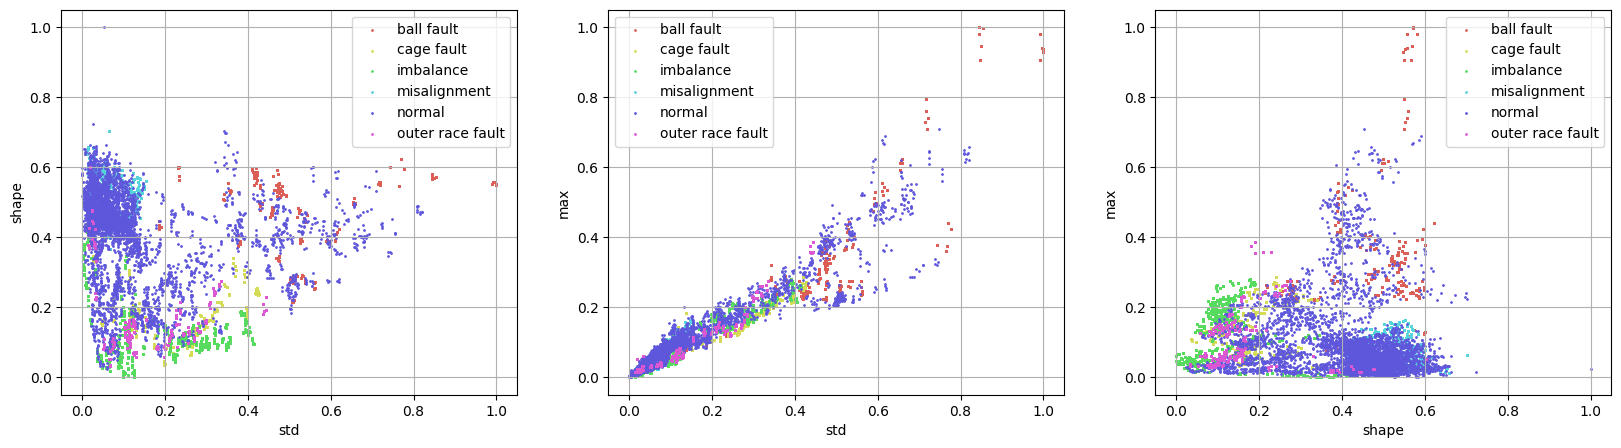

rpm_limit                    False
target                       fault
placement                        B
domain                    temporal
features     [pp, crest, skewness]
Name: 5, dtype: object


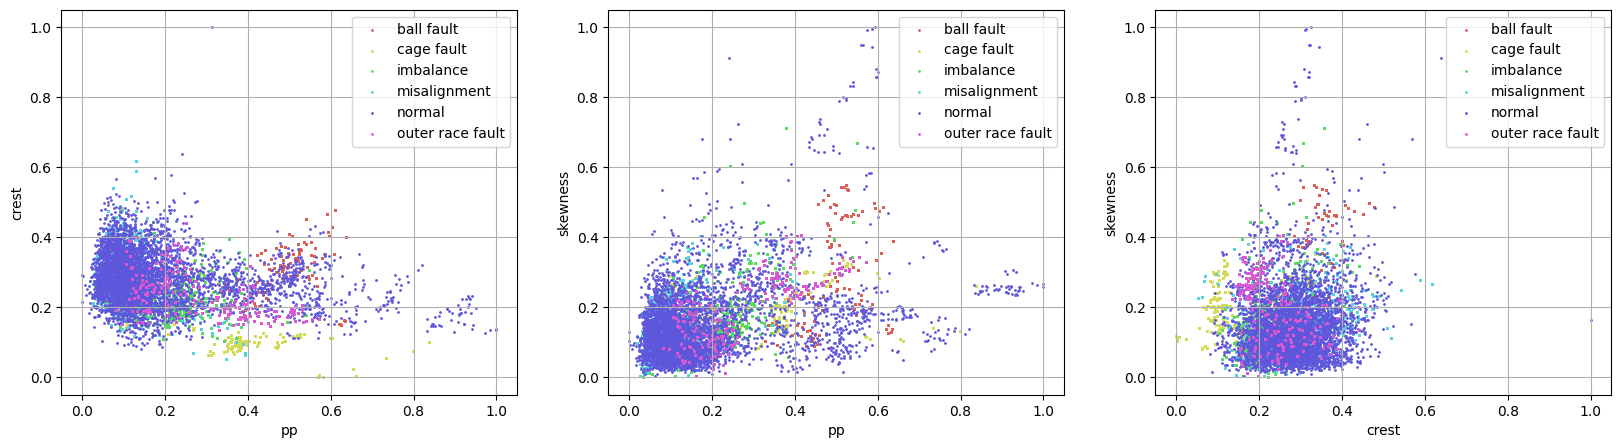

rpm_limit                             False
target                                fault
placement                                 A
domain                             spectral
features     [roll_off, centroid, skewness]
Name: 4, dtype: object


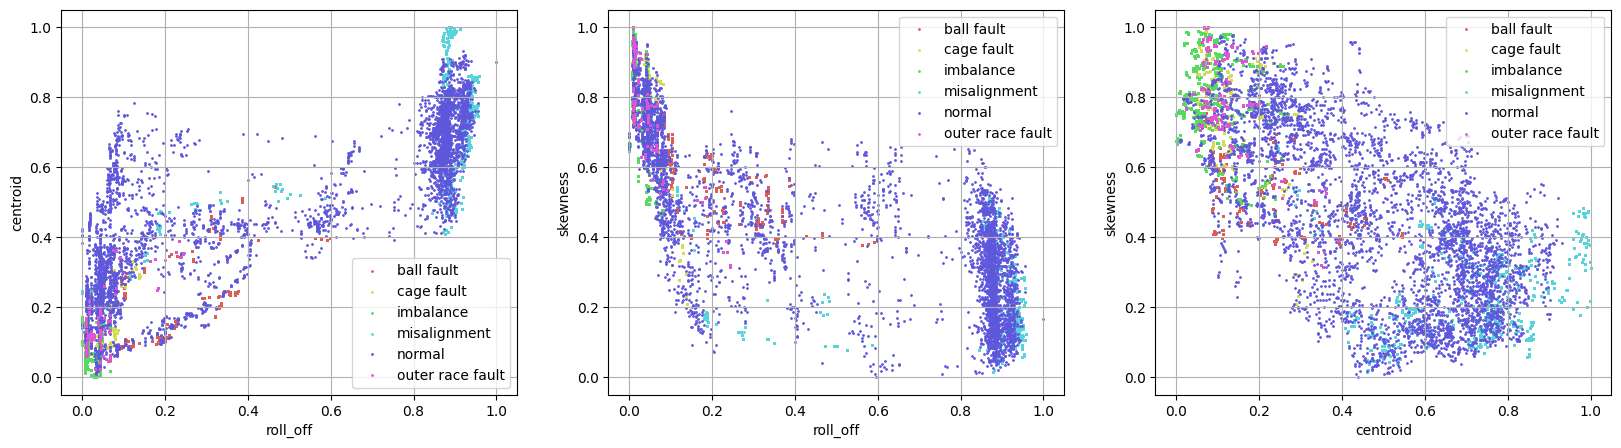

rpm_limit                            False
target                               fault
placement                                B
domain                            spectral
features     [centroid, roll_on, roll_off]
Name: 5, dtype: object


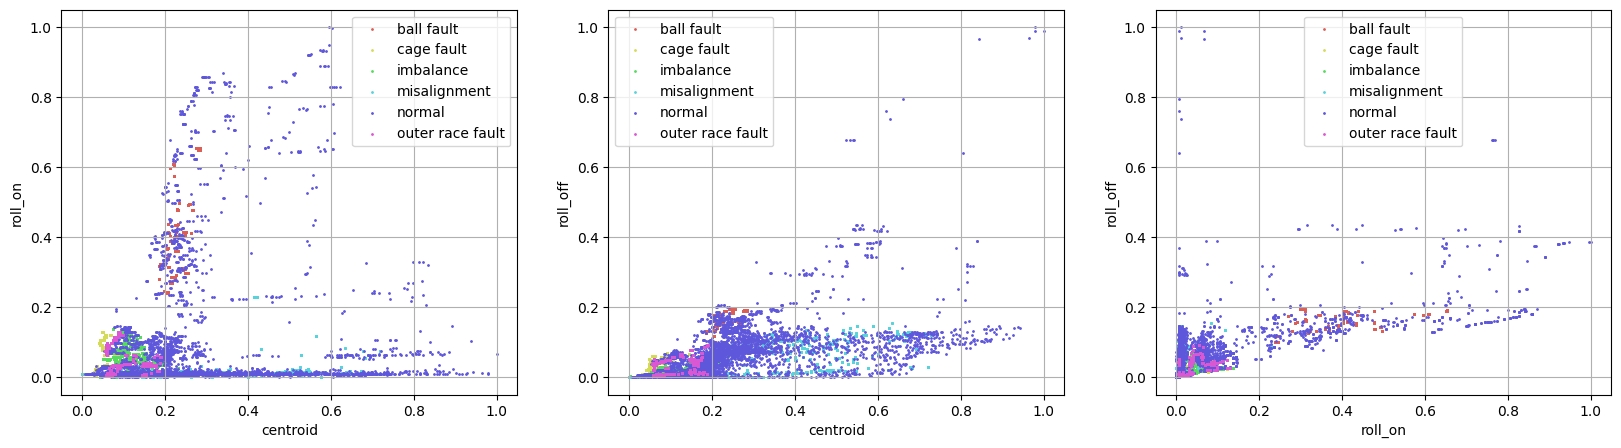

In [19]:
domains = {
    'temporal': TD_FEATURES,
    'spectral': FD_FEATURES
}
faults = features[features['target'] == 'fault']
for index, row in faults.iterrows():
    label = row['domain']
    dataset = domains[label]
    x_train, x_test, y_train, y_test = load_source(dataset, label, row)
    print(row)
    models.cross_cuts_3d(x_train[row['features']], y_train)
    plt.show()

In [ ]:
faults = features[features['target'] == 'anomaly_60']
for index, row in faults.iterrows():
    label = row['domain']
    dataset = domains[label]
    x_train, x_test, y_train, y_test = load_source(dataset, label, row)
    models.cross_cuts_3d_anomalies(x_train, y_train)
    plt.show()

In [ ]:
faults = features[features['target'] == 'anomaly_90']
for index, row in faults.iterrows():
    label = row['domain']
    dataset = domains[label]
    x_train, x_test, y_train, y_test = load_source(dataset, label, row)
    models.cross_cuts_3d_anomalies(x_train, y_train)
    plt.show()

Voronoi diagram of Nearest neighbors
- https://stackoverflow.com/questions/20515554/colorize-voronoi-diagram

---
#### (DEPRECATED SECTION): Find best k neighbors - elbow analysis

In [ ]:
k_values = list(range(3, 40, 2))
accuracies = get_knn_accuracies(k_values, X_train, y_train, X_test, y_test)
error_rates = get_knn_error_rates(k_values, X_train, y_train, X_test, y_test)
plot_knn_k_param(k_values, accuracies, error_rates)

### Change number of features
- evaluate kNN classification accuracies in each feature domain
  - features for each axis separately (x, y, z)
  - features in each measurement poins (a, b)

In [ ]:
TRAINING_SET_RATIO = 0.8
DIST_METRIC = 'euclidean'
FEATURE_SELECTION_METHOD = mutual_info_classif
KNN_K_VALUES = list(range(3, 20, 2))
WINDOW_SIZE = 2**14

def evaluate_knn_number_of_features(features_filename, domain):    
    results = []
    X_train0, y_train0, X_test0, y_test0 = models.load_feature_set(
        features_filename, 
        selection.FAULT_CLASSES,
        SOURCE_AXIS,
        'fault', 
        train_size=TRAINING_SET_RATIO, 
        anomaly_severity=ANOMALY_SEVERITY,
        balance=True,
        rpm_limit=False,
        window_size=WINDOW_SIZE,
        domain=domain
    )
    for n in tqdm(range(1, len(X_train0.columns) + 1)):
        X_train, X_test, y_train, y_test = models.pipeline_v1_core(
            FEATURE_SELECTION_METHOD, n,
            X_train0, y_train0, X_test0, y_test0
        )

        metric = get_knn_error_rates(KNN_K_VALUES, X_train, y_train, X_test, y_test)
        kneedle = KneeLocator(KNN_K_VALUES, metric, S=1.0, curve='convex', direction='decreasing')
        results.append([n, kneedle.elbow, kneedle.knee_y])
    
    return pd.DataFrame(results, columns=['n_features', 'k_neighbors', 'error_rate'])


def find_optimal_error_rate(success):
    plt.plot(success['n_features'], success['error_rate'])
    plt.grid()
    plt.xlabel('Number of features')
    plt.ylabel('Error rate')

    kneedle = KneeLocator(
        success['n_features'], success['error_rate'], 
        S=1.0, curve='convex', direction='decreasing'
    )
    best = success[success['n_features'] == kneedle.elbow]
    return best


def kfold_validate_knn(features_filename):
    features = pd.read_csv(FD_FEATURES)
    features = models.fault_labeling(features, selection.FAULT_CLASSES)
    columns = features.columns.str.startswith(tuple(['ax', 'ay', 'az']))
    X = features[features.columns[columns]]
    y = features['fault'].astype('category')

    # crossvalid = StratifiedShuffleSplit(n_splits=5, test_size=0.6, random_state=100)
    crossvalid = StratifiedKFold(n_splits=5)
    evaluation = []

    for train_index, test_index in tqdm(crossvalid.split(X, y)):
        X_train, y_train = X.iloc[train_index], y.iloc[train_index]
        X_test, y_test = X.iloc[test_index], y.iloc[test_index]

        X_train, X_test, y_train, y_test = models.pipeline_v1_core(
            FSEL_METHOD, N_FEATURES, 
            X_train, y_train, X_test, y_test
        )

        if DIST_METRIC == 'euclidean':
            d = 'euclidean'
        elif DIST_METRIC == 'mahalanobis':
            d = lambda x, y: mahalanobis(x, y, np.cov(X_train.T))
        elif DIST_METRIC == 'rbf':
            d = lambda x, y: np.exp(-euclidean(x, y)**2 * (1 / len(x)))

        knn = KNeighborsClassifier(n_neighbors=N_NEIGHBOURS, metric=d)
        knn.fit(X_train, y_train)
        y_predict_train = knn.predict(X_train)
        y_predict_test = knn.predict(X_test)

        evaluation.append({
            'train_accuracy': metrics.accuracy_score(y_train, y_predict_train),
            'train_precision': metrics.precision_score(y_train, y_predict_train, average='micro'),
            'train_recall': metrics.recall_score(y_train, y_predict_train, average='micro'),
            'test_accuracy': metrics.accuracy_score(y_test, y_predict_test),
            'test_precision': metrics.precision_score(y_test, y_predict_test, average='micro'),
            'test_recall': metrics.recall_score(y_test, y_predict_test, average='micro')
        })

    print(f'Most informative features: {list(X_train.columns)}')
    evaluation = pd.DataFrame.from_records(evaluation)
    print(evaluation.mean())